<a href="https://colab.research.google.com/github/FREDY129053/AI_Systems_LABS/blob/main/Lab_3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лаба 3.8: Кластеризация: алгоритмы K-means и EM

https://www.geeksforgeeks.org/machine-learning/k-means-clustering-introduction/

## Получение данных

In [1]:
!wget https://sci2s.ugr.es/keel/dataset/data/unsupervised/Quake.zip
!pip install patool

--2025-10-09 20:26:36--  https://sci2s.ugr.es/keel/dataset/data/unsupervised/Quake.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17262 (17K) [application/zip]
Saving to: ‘Quake.zip’

Quake.zip           100%[===================>]  16.86K  --.-KB/s    in 0.1s    

2025-10-09 20:26:37 (127 KB/s) - ‘Quake.zip’ saved [17262/17262]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=999d58235e68e263dc20673655cfc0cf012ada8f303d1ace0d61c7d783fb7e7e
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [3]:
import patoolib

patoolib.extract_archive('/content/Quake.zip')

INFO patool: Extracting /content/Quake.zip ...
INFO:patool:Extracting /content/Quake.zip ...
INFO patool: running /usr/bin/7z x -aou -o/content/Unpack_zf31vvzy -- /content/Quake.zip
INFO:patool:running /usr/bin/7z x -aou -o/content/Unpack_zf31vvzy -- /content/Quake.zip
INFO patool: ... /content/Quake.zip extracted to `quake.dat'.
INFO:patool:... /content/Quake.zip extracted to `quake.dat'.


'quake.dat'

In [4]:
import pandas as pd

# Кастомный парсер, т.к. либы не могут прочитать файл из-за какой-то ошибки в строке 5-6
def read_arff_dat(path):
    with open(path, "r") as f:
        lines = f.readlines()

    data_start = 0
    attrs = []
    for i, ln in enumerate(lines):
        ln = ln.strip()
        if ln.lower().startswith("@attribute"):
            parts = ln.split()
            attrs.append(parts[1])
        if ln.lower().startswith("@data"):
            data_start = i + 1
            break

    data_lines = [ln.strip() for ln in lines[data_start:] if ln.strip() and not ln.startswith("%")]
    rows = []
    for ln in data_lines:
        parts = ln.split(",")
        row = []
        for p in parts:
            try:
                if "." in p:
                    row.append(float(p))
                else:
                    row.append(int(p))
            except ValueError:
                row.append(p)
        rows.append(row)

    df = pd.DataFrame(rows, columns=attrs)
    return df

df = read_arff_dat('quake.dat')
print(f"Размерность данных: {df.shape}")
df.head()

Размерность данных: (2178, 4)


,Focal_depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [5]:
n = 3

### KMeans

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Снижение размерности
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

print("Доля объяснённой дисперсии (2 компоненты):", np.sum(pca.explained_variance_ratio_))

Доля объяснённой дисперсии (2 компоненты): 0.5555855295507786


In [ ]:
from sklearn.cluster import KMeans

model_kmeans = KMeans(n_clusters=n, init='random', algorithm='elkan', max_iter=100000, random_state=42)

labels = model_kmeans.fit_predict(df_scaled)
centers = model_kmeans.cluster_centers_

centers_pca = pca.transform(centers)

#### Визуализацияя компонент с помощью UMAP алгоритма для сохранения расстояний

https://habr.com/ru/companies/newprolab/articles/350584/

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



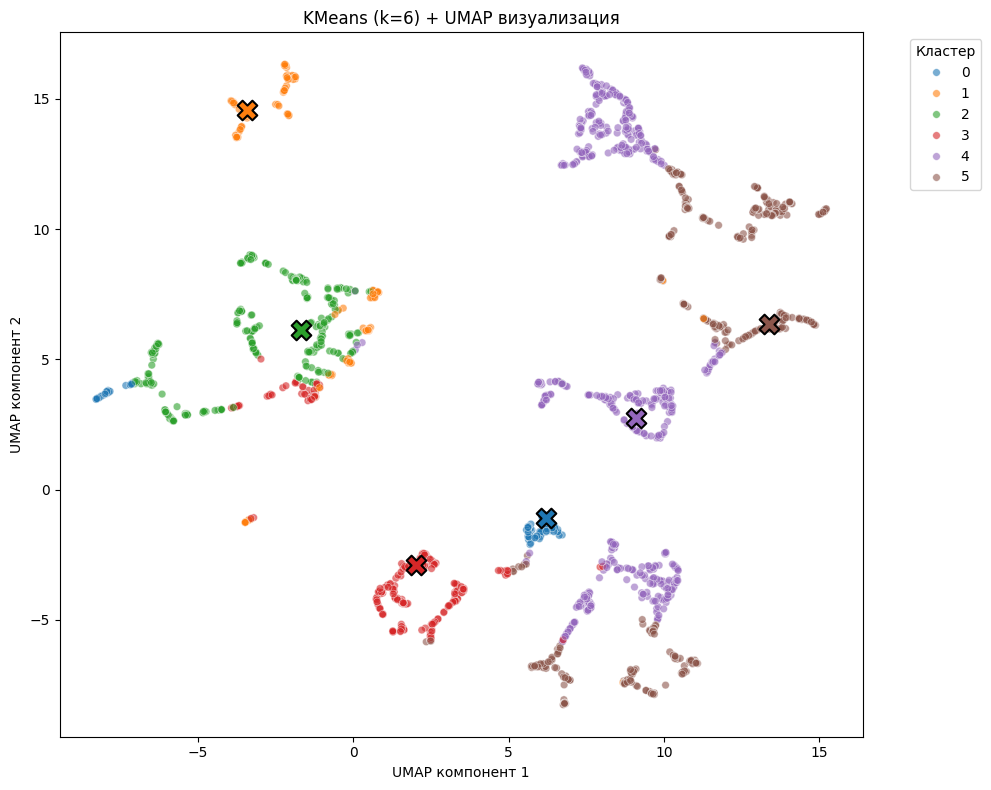

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

um = umap.UMAP(n_components=2, random_state=42)
X_umap = um.fit_transform(df_scaled)
centers_umap = um.transform(centers)


plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", n)

sns.scatterplot(
    x = X_umap[:, 0], y = X_umap[:, 1],
    hue = labels,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(n):
    xi, yi = centers_umap[i, 0], centers_umap[i, 1]
    color_i = palette[i % len(palette)]
    plt.scatter(
        xi, yi,
        color = color_i,
        marker = "X",
        s = 200,
        edgecolor = "k",
        linewidth = 1.5
    )

plt.title(f"KMeans (k={n}) + UMAP визуализация")
plt.xlabel("UMAP компонент 1")
plt.ylabel("UMAP компонент 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Визуализация двух главных компонент базово, но не очень видно группировку по классам

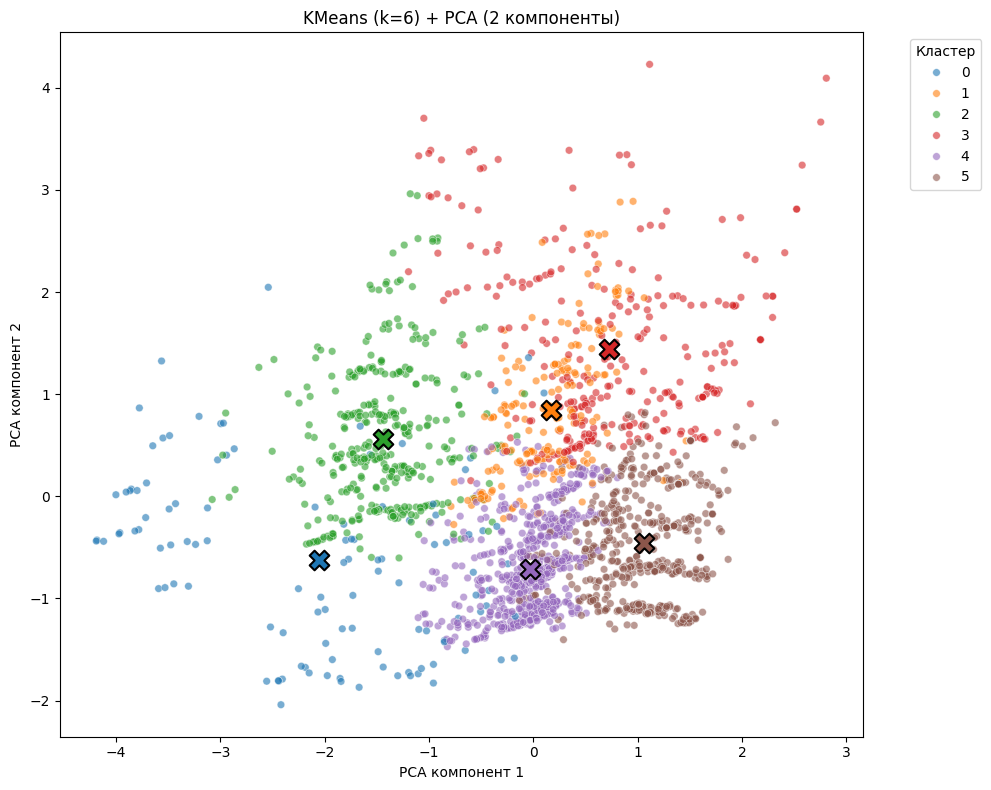

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", n)

# Точки:
sns.scatterplot(
    x = df_pca[:, 0], y = df_pca[:, 1],
    hue = labels,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

# Центры:
for i in range(n):
    xi, yi = centers_pca[i, 0], centers_pca[i, 1]
    color_i = palette[i % len(palette)]
    plt.scatter(
        xi, yi,
        color = color_i,
        marker = "X",
        s = 200,
        edgecolor = "k",
        linewidth = 1.5
    )

plt.title(f"KMeans (k={n}) + PCA (2 компоненты)")
plt.xlabel("PCA компонент 1")
plt.ylabel("PCA компонент 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### EM

In [6]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

# Снижение размерности
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

print("Доля объяснённой дисперсии (2 компоненты):", np.sum(pca.explained_variance_ratio_))

model_em = GaussianMixture(n_components=n, random_state=42, init_params='random', max_iter=10000)

labels = model_em.fit_predict(df_scaled)
centers = model_em.means_

Доля объяснённой дисперсии (2 компоненты): 0.5555855295507786


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


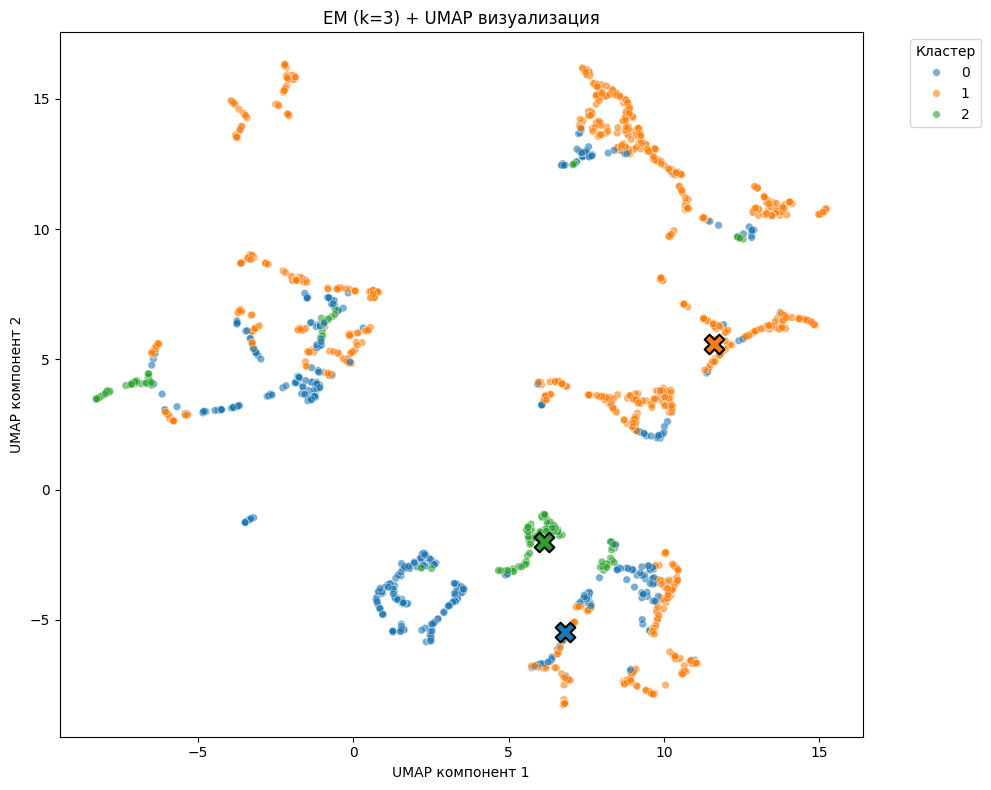

In [7]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

um = umap.UMAP(n_components=2, random_state=42)
X_umap = um.fit_transform(df_scaled)
centers_umap = um.transform(centers)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", n)

sns.scatterplot(
    x = X_umap[:, 0], y = X_umap[:, 1],
    hue = labels,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(n):
    xi, yi = centers_umap[i, 0], centers_umap[i, 1]
    color_i = palette[i % len(palette)]
    plt.scatter(
        xi, yi,
        color = color_i,
        marker = "X",
        s = 200,
        edgecolor = "k",
        linewidth = 1.5
    )

plt.title(f"EM (k={n}) + UMAP визуализация")
plt.xlabel("UMAP компонент 1")
plt.ylabel("UMAP компонент 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Практические задания

### 1. Построить графики показателей (сумма квадратов расстояний, отношение среднего внутрикластерного расстояния к внекластерному) для различного количества кластеров для набора данных Quake. Определить оптимальное число кластеров, анализируя эмпирическую информацию распределения «очагов».

In [ ]:
start_clusters = 2
end_clusters = 25

In [ ]:
from sklearn.metrics import silhouette_score

inertia = []
silhouettes = []

for k in range(start_clusters, end_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=100000)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

    labels_k = kmeans.fit_predict(df_scaled)
    sil = silhouette_score(df_scaled, labels_k)
    silhouettes.append(sil)

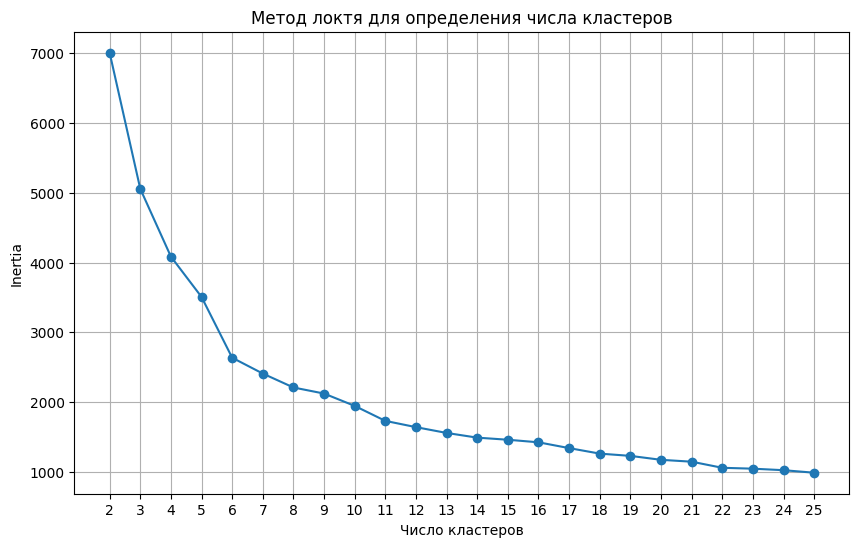

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), inertia, marker='o')
plt.title("Метод локтя для определения числа кластеров")
plt.xlabel("Число кластеров")
plt.ylabel("Inertia")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

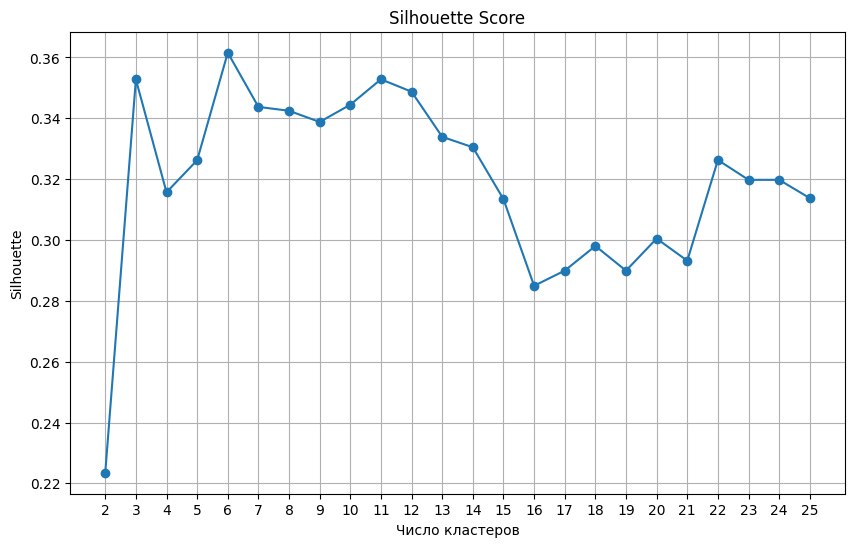

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), silhouettes, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

На основе метода локтя оптимальное кол-во кластеров 5-6, но Silhouette Score позволяет увидеть, что 6 более оптимально

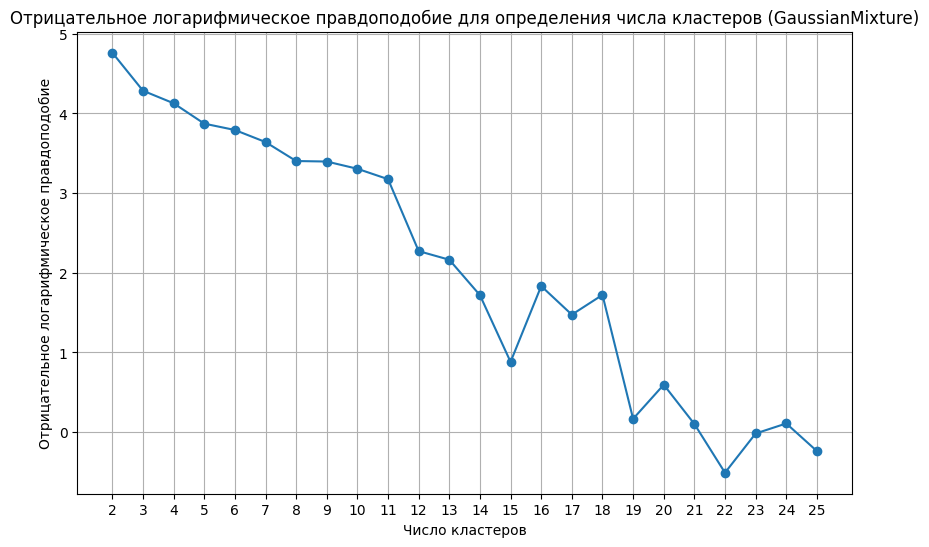

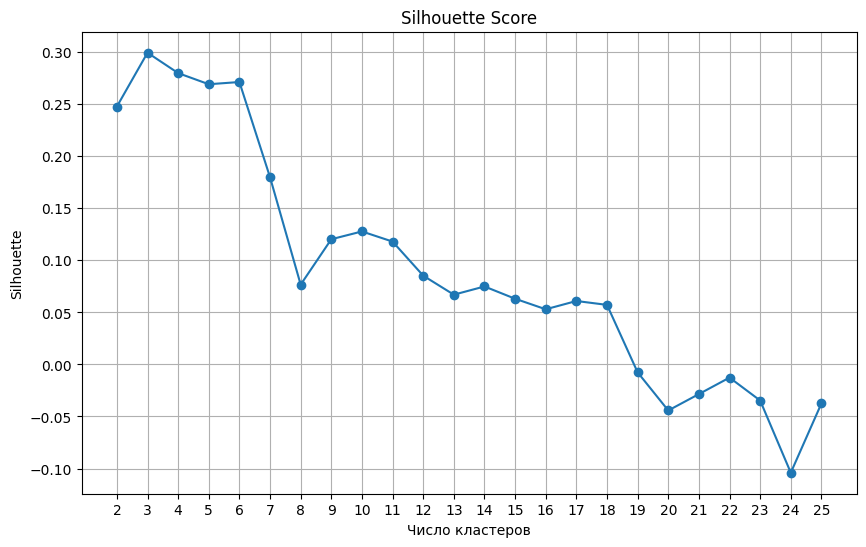

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

start_clusters = 2
end_clusters = 25
inertia = []
silhouettes = []

for k in range(start_clusters, end_clusters + 1):
    kmeans = GaussianMixture(n_components=k, random_state=42, init_params='k-means++', max_iter=10000)
    kmeans.fit(df_scaled)
    inertia.append(-kmeans.score(df_scaled))

    labels_k = kmeans.predict(df_scaled)
    sil = silhouette_score(df_scaled, labels_k)
    silhouettes.append(sil)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), inertia, marker='o')
plt.title("Отрицательное логарифмическое правдоподобие для определения числа кластеров (GaussianMixture)")
plt.xlabel("Число кластеров")
plt.ylabel("Отрицательное логарифмическое правдоподобие")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), silhouettes, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()